[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In the agriculture, for the problem of **data scarcity**, several techniques have been used by researchers to create more images based on the available datasets. The one which is shown in this notebook is data augmentation by performing different geometric and colour transformations into the images (**Dyrmann et al., 2016; Mehdipour-Ghazi et al., 2017; Fuentes et al., 2017; **). Data augmentation is not only useful for improving the performance of the deep neural network, but also for reducing <a href="https://en.wikipedia.org/wiki/Overfitting">overfitting</a>.

With this **data augmentation** set of techniques, images can be **rotated** by various angles, **cropped**, **scaled**, **blurred**, **noised**, **gray-scaled**, or **mirrored**.

#### Additional installations

In [39]:
!pip install -q tf-models-official
!pip install -q opencv-python-headless==4.1.2.30

#### Library Imports

In [40]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import csv
import gc
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import mobilenet_v3
import tensorflow.keras.backend as K

from official.vision.image_classification.augment import RandAugment

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

#### Auxiliar functions
Check the docstrings for more information.

In [41]:
# Function for plotting images.
def plot_samples(dataset):
    """
    Given a TF dataset, this functions displays 4 images (2x2)
    """
    sample_images, sample_labels = next(iter(dataset))

    plt.figure(figsize=(8, 8))
    for ix, sample_image in enumerate(sample_images[:4]):
        plt.subplot(2, 2, ix + 1)
        plt.imshow(sample_image.numpy().astype(np.uint8))
        plt.axis("off")

    plt.show()


def read_data(path_list, im_size=(224, 224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                # im = quantize_image(im)
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)

    return X, y


# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(patience):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [
        # If val_loss doesn't improve for a number of epochs set with 'patience' var
        # training will stop to avoid overfitting.
        EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=patience,
            restore_best_weights=True,
            verbose=1,
        )
    ]

#### Experimental Constants

In [42]:
INPUT_SHAPE = (224, 224, 3)
IM_SIZE = (224, 224)
NUM_EPOCHS = 30
BATCH_SIZE = 8
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2
RANDOM_STATE = 2022
WEIGHTS_FILE = "weights.h5"  # File that stores updated weights
AUTO = tf.data.AUTOTUNE
# Datasets' paths we want to work on.

PATH_LIST = [
    "eden_library_datasets/Orange tree-060521-K deficiency-zz-V1-20210721140920",
    "eden_library_datasets/Orange tree-060521-Mg deficiency-zz-V1-20210721140926",
]

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#### Loading images and Data Loaders
In this notebook, we use 2 nutrient deficiency datasets.

In [43]:
i = 0
for path in PATH_LIST:
    # Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path))
    i += 1
X, y = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 45/45 [00:04<00:00,  9.59it/s]


#### Function for loading a pre-trained architecture

In [44]:
def get_architecture(y, mobilenet_size="small", optimizer="adam", 
                     learning_rate=1e-3, use_scheduler=False):
    """
    Given the parameters, it returns a compiled architecture (MobileNetV3)
    ready for training.
    """
    inputs = layers.Input(shape=INPUT_SHAPE)
    # input_aug = img_augmentation(inputs)
    input_norm = layers.Lambda(mobilenet_v3.preprocess_input)(
        inputs
    )  # placeholder in this case

    if mobilenet_size == "small":
        feature_extractor = MobileNetV3Small(
            weights="imagenet", include_top=False, input_tensor=input_norm
        )
    elif mobilenet_size == "large":
        feature_extractor = MobileNetV3Large(
            weights="imagenet", include_top=False, input_tensor=input_norm
        )

    # Create new model on top.
    feataures = layers.GlobalAveragePooling2D(name="pool")(
        feature_extractor.output
    )  # Flattening layer.
    fully = layers.Dense(units=64, activation="relu")(
        feataures
    )  # Add a fully connected layer.
    # Create a Classifier with shape=number_of_training_classes.
    fully = layers.Dropout(0.3)(fully)  # Regularize with dropout.
    out = layers.Dense(units=y.shape[1], activation="softmax")(fully)
    # This is the final model.
    model = Model(inputs, out)

    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        print("[ERROR] Unknown optimizer")

    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )
    # model.summary()
    return model

In [45]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT, shuffle=True, stratify=y, random_state=RANDOM_STATE
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=VAL_SPLIT,
    shuffle=True,
    stratify=y_train,
    random_state=RANDOM_STATE,
)

## Creating the augmenation object
You can change the "num_layers" and "magnitude" parameters for obtaining different augmentations.

In [46]:
augmenter = RandAugment(num_layers=3, magnitude=7)

#### Creating the TF datasets from the Numpy arrays

In [47]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

clean_train_ds = (
    train_ds.shuffle(BATCH_SIZE, seed=RANDOM_STATE).batch(BATCH_SIZE).prefetch(AUTO)
)

noisy_train_ds = (
    train_ds.shuffle(BATCH_SIZE, seed=RANDOM_STATE)
    .map(lambda x, y: (augmenter.distort(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

#### Displaying Original (resized) Images

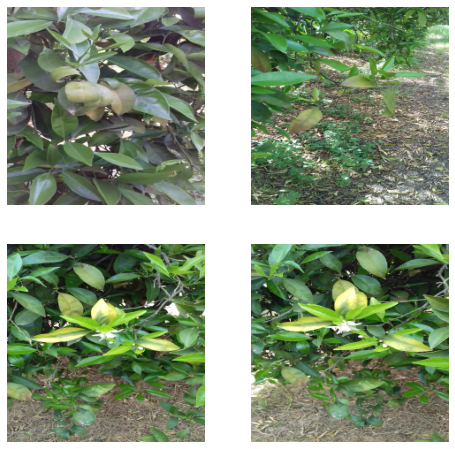

In [49]:
plot_samples(clean_train_ds)

#### Displaying Noisy (resized) Images

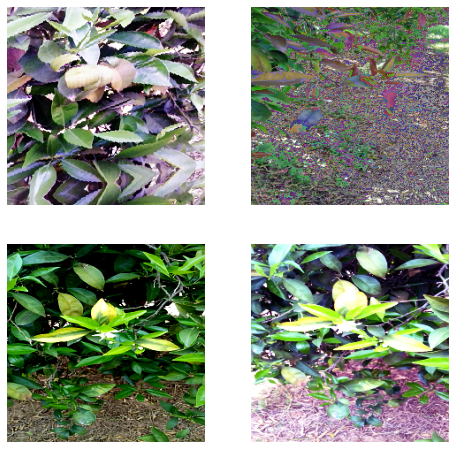

In [50]:
plot_samples(noisy_train_ds)

#### Displaying more noisy images
It is important to verify that the images are realistic enough. For the sake of knowledge gaining, in this notebook, we try excessive distortions to check the limits of the RandAumgent library.

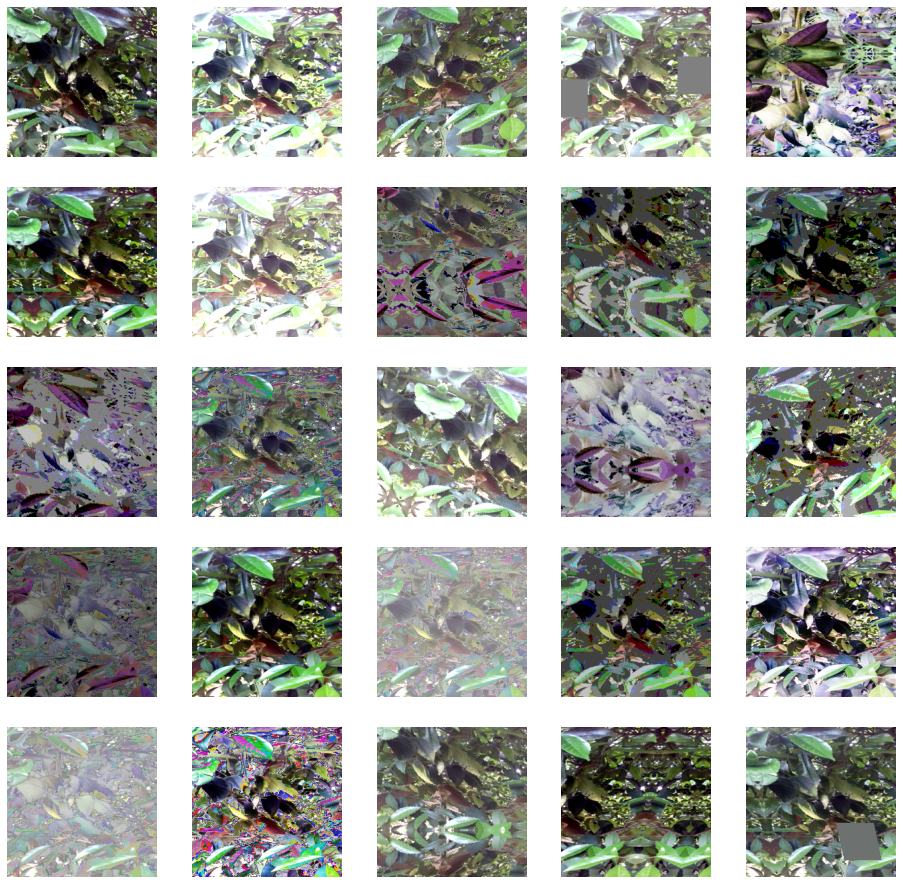

In [51]:
sample_images, sample_labels = next(iter(clean_train_ds))

for sample_image in sample_images[:1]:
    continue

plt.figure(figsize=(16, 16))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    aug_img = augmenter.distort(sample_image)
    plt.imshow(aug_img.numpy().astype("uint8"))
    plt.axis("off")
plt.show()

#### Training / Fine-Tuning Models

In [52]:
%%time
# Loading Model
model = get_architecture(
    y, mobilenet_size="small", optimizer="adam", learning_rate=1e-3, use_scheduler=False
)

# Training
history_clean = model.fit(
    clean_train_ds,  # train data
    validation_data=val_ds,  # labels
    epochs=NUM_EPOCHS,
    callbacks=get_callbacks(NUM_EPOCHS // 2),
)

Epoch 1/30
7/7 [==============================] - 4s 148ms/step - loss: 0.7781 - accuracy: 0.6327 - val_loss: 1.3472 - val_accuracy: 0.3846
Epoch 2/30
7/7 [==============================] - 0s 39ms/step - loss: 0.1618 - accuracy: 0.9388 - val_loss: 0.5661 - val_accuracy: 0.6923
Epoch 3/30
7/7 [==============================] - 0s 40ms/step - loss: 0.1317 - accuracy: 0.9592 - val_loss: 0.5608 - val_accuracy: 0.7692
Epoch 4/30
7/7 [==============================] - 0s 33ms/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.7679 - val_accuracy: 0.7692
Epoch 5/30
7/7 [==============================] - 0s 34ms/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 1.0612 - val_accuracy: 0.8462
Epoch 6/30
7/7 [==============================] - 0s 32ms/step - loss: 0.1916 - accuracy: 0.9388 - val_loss: 0.7304 - val_accuracy: 0.7692
Epoch 7/30
7/7 [==============================] - 0s 33ms/step - loss: 0.1506 - accuracy: 0.9184 - val_loss: 1.9050 - val_accuracy: 0.3846
Epoch 8/30
7/7 [==========

#### Printing Performance on the Test set

In [53]:
print()
print("*" * 50)
print(f"Clean Train - Test Accuracy: {model.evaluate(test_ds, verbose=0)[1]}")
print("*" * 50)
print()


**************************************************
Clean Train - Test Accuracy: 0.875
**************************************************



In [54]:
# Loading Model
model = get_architecture(
    y, mobilenet_size="small", optimizer="adam", learning_rate=1e-3, use_scheduler=False
)

# Training Model
history_noisy = model.fit(
    noisy_train_ds,  # train data
    validation_data=val_ds,  # labels
    epochs=NUM_EPOCHS,
    callbacks=get_callbacks(NUM_EPOCHS // 2),
)

Epoch 1/30
7/7 [==============================] - 5s 147ms/step - loss: 0.9208 - accuracy: 0.5102 - val_loss: 0.8055 - val_accuracy: 0.3846
Epoch 2/30
7/7 [==============================] - 0s 38ms/step - loss: 0.6840 - accuracy: 0.6735 - val_loss: 0.5332 - val_accuracy: 0.6923
Epoch 3/30
7/7 [==============================] - 0s 38ms/step - loss: 0.5524 - accuracy: 0.8163 - val_loss: 0.1730 - val_accuracy: 1.0000
Epoch 4/30
7/7 [==============================] - 0s 33ms/step - loss: 0.4760 - accuracy: 0.8367 - val_loss: 0.2406 - val_accuracy: 0.9231
Epoch 5/30
7/7 [==============================] - 0s 31ms/step - loss: 0.2867 - accuracy: 0.8980 - val_loss: 0.4372 - val_accuracy: 0.6923
Epoch 6/30
7/7 [==============================] - 0s 31ms/step - loss: 0.3445 - accuracy: 0.7959 - val_loss: 0.2924 - val_accuracy: 0.8462
Epoch 7/30
7/7 [==============================] - 0s 33ms/step - loss: 0.5364 - accuracy: 0.8163 - val_loss: 0.3472 - val_accuracy: 0.8462
Epoch 8/30
7/7 [==========

#### Printing Performance on the Test set

In [55]:
print()
print("*"*50)
print(f"Noisy Train - Test Accuracy: {model.evaluate(test_ds, verbose=0)[1]}")
print("*"*50)
print()


**************************************************
Noisy Train - Test Accuracy: 0.9375
**************************************************

CPU times: user 49.3 ms, sys: 9.42 ms, total: 58.7 ms
Wall time: 37.9 ms


## Conclusions
Data augmentation is very important pre-processing step and should be fine-tuned as any other hyper-parameter.

## Possible Extensions
1. Try different values of "num_layers" and "magnitude" when creating the RandAugment object.
2. Use a different pre-trained network (for instance, MobileNetV3Large).
3. Try a different training approach where pre-trained weights are not loaded.
4. Try different epochs and batch sizes.

## Bibliography
<a id='references'></a>
Binguitcha-Fare, A., & Sharma, P. (2019). Crops and weeds classification using Convolutional Neural Networks via optimization of transfer learning parameters.

Dyrmann, M., Karstoft, H., & Midtiby, H.S. (2016). Plant species classification using deep convolutional neural networks. Biosystems Engineering, 151, 72-80.

Mehdipour-Ghazi, M., Yanikoglu, B.A., & Aptoula, E. (2017). Plant identification using deep neural networks via optimization of transfer learning parameters. Neurocomputing, 235, 228-235.

Fuentes, A., Yoon, S., Kim, S., & Park, D. (2017). A Robust Deep-Learning-Based Detector for Real-Time Tomato Plant Diseases and Pests Recognition. Sensors (Basel, Switzerland), 17.